Processing 999 tickers...


363it [00:00, 656.45it/s]/var/folders/cy/vv8rw3d12f31t1wpxpbdgmtm0000gp/T/ipykernel_81986/127993833.py:59: UserWarning: Warning: converting a masked element to nan.
  sigmas[iticker] = info['compare_sp500']['diff_ratio']


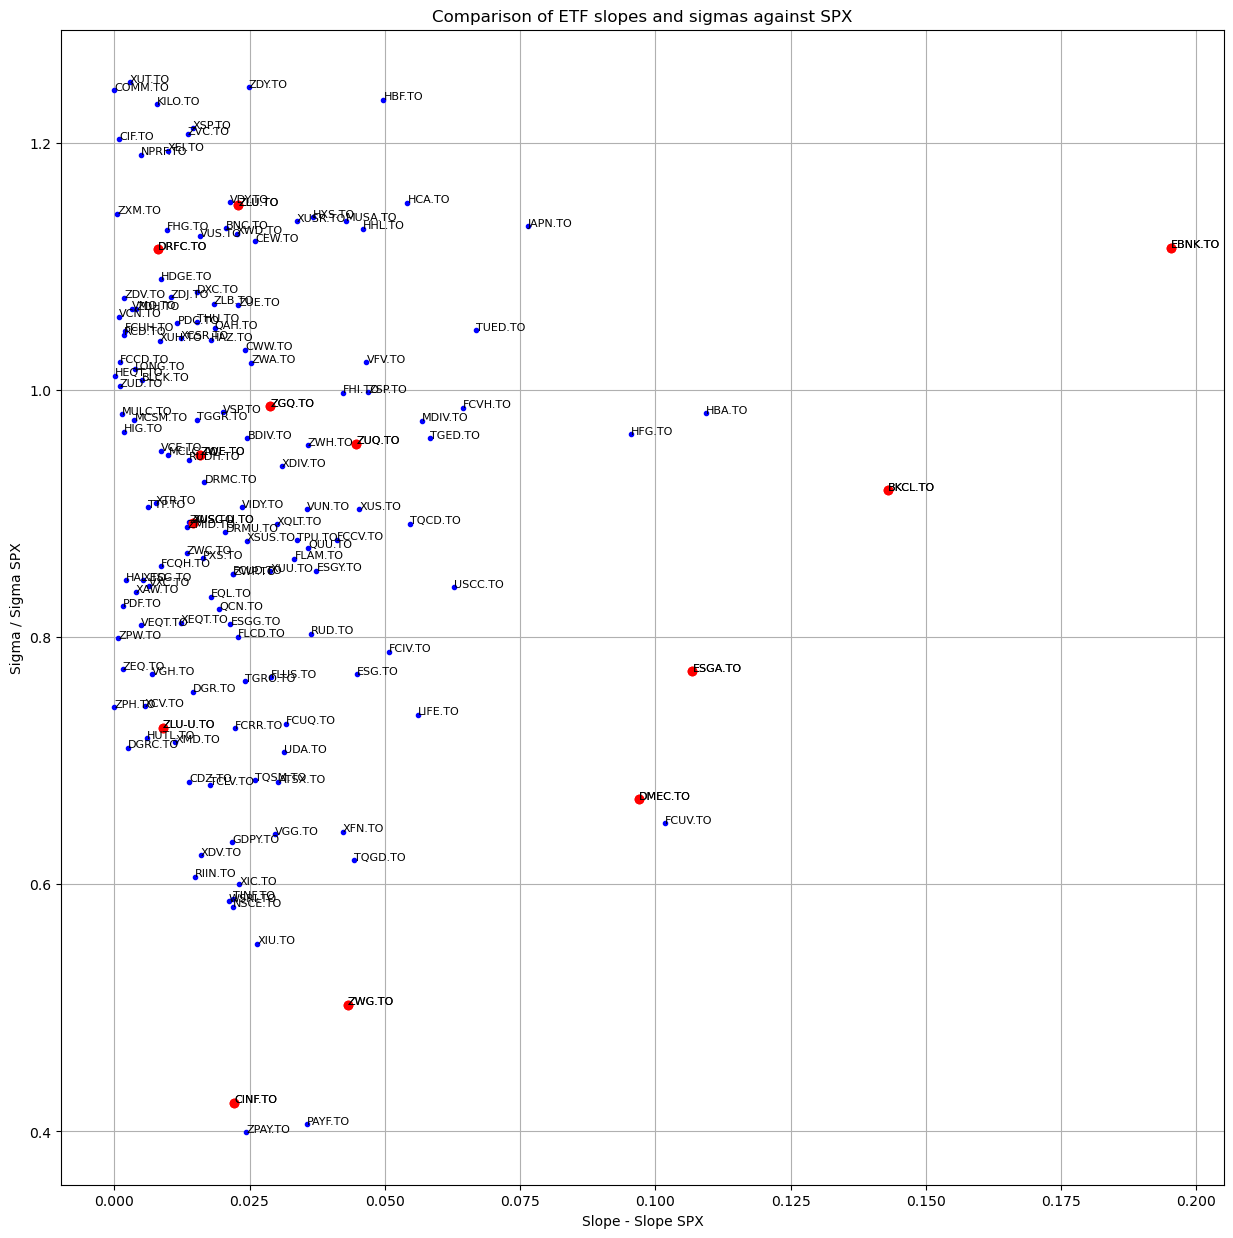

posx and posy should be finite values
posx and posy should be finite values


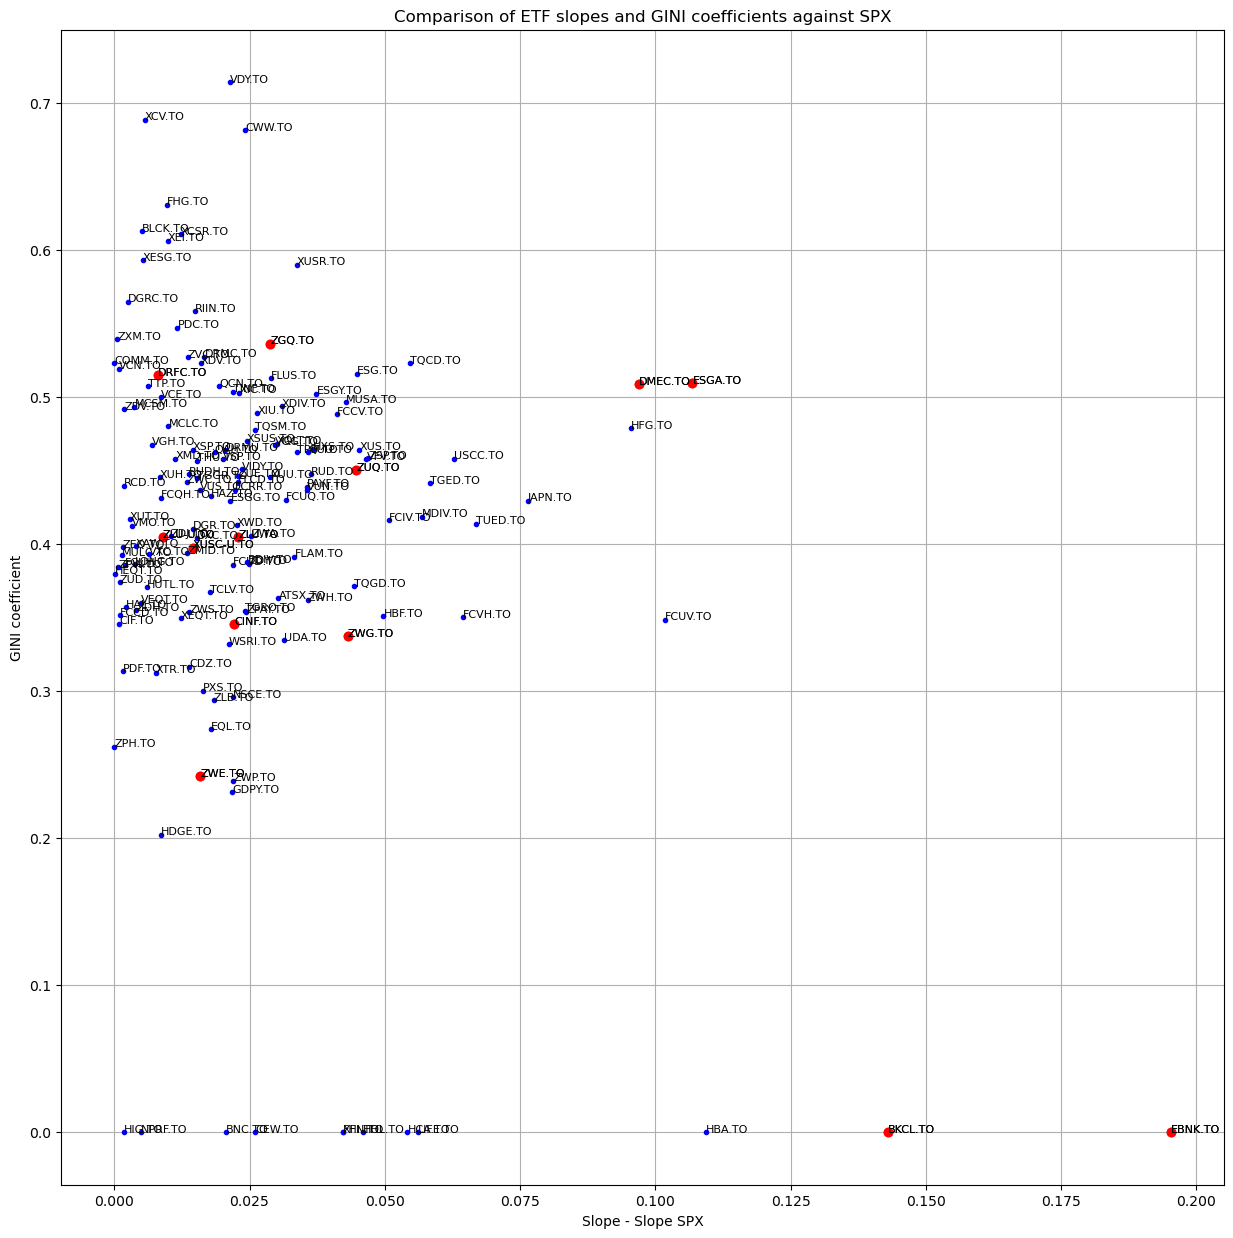

In [6]:
import bydoux_tools as bt
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy.table import Table

tbl_current = Table.read('current_symbols.csv')
current = tbl_current['symbols'].data
current_symbols = [s.replace('-C', '.TO') for s in current]
current_symbols = [s.replace('.U.TO', '-U.TO') for s in current_symbols]

etf_table = 'summary_ETF.csv'

# List of BMO ETF tickers (with some non-ETF entries, but filtered later)

tbl = Table.read(etf_table,format='ascii.tab')

bad = np.zeros(len(tbl), dtype=bool)
# check if these is a 'FAIL' in the comment column
for i, comment in enumerate(tbl['comment']):
    if 'FAIL' in comment.upper():
        bad[i] = True
tbl = tbl[~bad]    


tickers = tbl['Ticker'].data
# Check if BMP in longName
keep = np.zeros(len(tickers), dtype=bool)
for i, ticker in enumerate(tickers):
    if 'BMO' in tbl['longName'][i]:
        keep[i] = True

tickers = np.concatenate([tickers, current_symbols])

# Arrays to store results for each ticker
time_spans = np.zeros(len(tickers))  # Time span of data in years
slopes = np.zeros(len(tickers))      # Linear fit slope (log return per year)
sigmas = np.zeros(len(tickers))      # Standard deviation of residuals
q = np.zeros(len(tickers))           # Quality metric (slope/sigma)
gini = np.zeros(len(tickers))          # Gini coefficient for sector distribution
all_data = dict()

print(f"Processing {len(tickers)} tickers...")
verbose = True  # Set to True for detailed output
for iticker, ticker in tqdm(enumerate(tickers),leave = False):
    try:
        info = bt.get_info(ticker)
    except:
        if verbose:
            print(f"Failed to get info for {ticker}, skipping.")
            tbl = Table.read(etf_table,format='ascii.tab')
            if ticker in tbl['Ticker'].data:
                i = np.where(tbl['Ticker'].data == ticker)[0][0]
                tbl['comment'][i] = 'FAIL: no data'
                tbl.write(etf_table,format='ascii.tab',overwrite=True)
        continue

    slopes[iticker] = info['compare_sp500']['diff_slope']
    sigmas[iticker] = info['compare_sp500']['diff_ratio']

    # Time span in years
    time_spans[iticker] = info['compare_sp500']['overlap_years']
    if ticker in current_symbols:
        time_spans[iticker]=np.inf
    gini[iticker] = info['sectors']['gini']

# Filter: keep only ETFs with enough data, reasonable slope, and nonzero sigma
keep = (sigmas != 0) & (time_spans > 5) & (slopes > 0) & (sigmas < 1.25)
tickers = tickers[keep]
slopes = slopes[keep]
sigmas = sigmas[keep]
time_spans = time_spans[keep]
gini = gini[keep]



xlim = [-0.02, 0.2]
ylim = [0, 2]

fig, ax = plt.subplots(figsize=(15, 15))
for iticker, ticker in enumerate(tickers):
    slope = slopes[iticker]
    sig = sigmas[iticker]

    #print(f"{ticker:10s} slope: {slope:.6f} sig: {sig:.6f}  slope_spx: {slope_spx:.6f} sig_spx: {sig_spx:.6f}")

    sym = '.'
    color = 'blue'
    if ticker in current_symbols:
        sym = 'o'
        color = 'red'
    ax.plot(slope, sig, sym, label=ticker, color=color)
    #if (xlim[0] <= slope <= xlim[1]) and (ylim[0] <= sig <= ylim[1]):
    ax.text(slope , sig, ticker, fontsize=8)

    #ax.text(slope - slope_spx, sig/sig_spx, ticker, fontsize=8)
ax.set_xlabel('Slope - Slope SPX')
ax.set_ylabel('Sigma / Sigma SPX')
ax.set_title('Comparison of ETF slopes and sigmas against SPX')
#ax.set_xlim(xlim)
#ax.set_ylim(ylim)

#plt.legend()
ax.grid(True)
#plt.savefig('etf_comparison.pdf', dpi=300)
plt.show()





fig, ax = plt.subplots(figsize=(15, 15))
for iticker, ticker in enumerate(tickers):
    slope = slopes[iticker]
    gini_ticker = gini[iticker]
    sig = sigmas[iticker]

    #print(f"{ticker:10s} slope: {slope:.6f} sig: {sig:.6f}  slope_spx: {slope_spx:.6f} sig_spx: {sig_spx:.6f}")

    sym = '.'
    color = 'blue'
    if ticker in current_symbols:
        sym = 'o'
        color = 'red'

    #if sig>1.0:
    #    continue
    ax.plot(slope, gini_ticker, sym, label=ticker, color=color)
    ax.text(slope , gini_ticker, ticker, fontsize=8)

    #ax.text(slope - slope_spx, sig/sig_spx, ticker, fontsize=8)
ax.set_xlabel('Slope - Slope SPX')
ax.set_ylabel('GINI coefficient')
ax.set_title('Comparison of ETF slopes and GINI coefficients against SPX')
#ax.set_xlim(xlim)
#ax.set_ylim([0, 1])
#plt.legend()
ax.grid(True)
#plt.savefig('etf_comparison.pdf', dpi=300)
plt.show()

